In [ ]:
#!/bin/bash
# !curl -L -o aflw2000-3d.zip https://www.kaggle.com/api/v1/datasets/download/mohamedadlyi/aflw2000-3d

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 83.4M    0 16341    0     0  11681      0  2:04:48  0:00:01  2:04:47 11681
  0 83.4M    0  303k    0     0   130k      0  0:10:52  0:00:02  0:10:50  311k
  2 83.4M    2 2128k    0     0   629k      0  0:02:15  0:00:03  0:02:12 1064k
  4 83.4M    4 4112k    0     0   951k      0  0:01:29  0:00:04  0:01:25 1401k
  7 83.4M    7 6128k    0     0  1151k      0  0:01:14  0:00:05  0:01:09 1558k
  9 83.4M    9 8496k    0     0  1344k      0  0:01:03  0:00:06  0:00:57 1723k
 12 83.4M   12 10.6M    0     0  1490k      0  0:00:57  0:00:07  0:00:50 2122k
 14 83.4M   14 12.3M    0     0  1518k      0  0:0

In [ ]:
# !unzip aflw2000-3d.zip -d aflw2000-3d

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# import os
# data_dir = r'data/AFLW2000'
# image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
# print(f'Total images found: {len(image_files)}')

Total images found: 2000


In [ ]:
# def explore_folder(folder_path):
#     print(f"Exploring files in: {folder_path}\n")
    
#     # Walk through all subdirectories and files
#     for root, dirs, files in os.walk(folder_path):
#         print(f"Current Directory: {root}")
        
#         # List subdirectories
#         if dirs:
#             print("  Subdirectories:")
#             for d in dirs:
#                 print(f"    📁 {d}")
        
#         # List files
#         if files:
#             print("  Files:")
#             for f in files:
#                 print(f"    📄 {f}")
        
#         print("-" * 50)

# # Example usage
# if __name__ == "__main__":
#     folder_path = input("Enter the folder path to explore: ").strip()
    
#     if os.path.exists(folder_path):
#         explore_folder(folder_path)
#     else:
#         print("❌ The provided path does not exist.")

In [23]:
# ==============================
# 🔹 3D Face Recognition — Visualization
# ==============================

import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE


In [21]:
# ---------------------------
# Define paths (relative to notebook)
# ---------------------------
data_root = "data/processed/test"
model_path ="checkpoints\best_model.keras"
image_root = "data/AFLW2000"

In [25]:
# ---------------------------
# Load trained model with custom objects
# ---------------------------
print("[INFO] Loading trained ST-GCN model...")

# Import your custom layers
from src.stgcn_layers import STGCNBlock
from src.graph_utils import build_adjacency_matrix

# Register custom objects used inside your model
custom_objects = {
    "STGCNBlock": STGCNBlock
}

# Ensure correct model path (avoid backslash escape issues)
# Use os.path.join so the path is formed correctly on all platforms
model_path = os.path.join("checkpoints", "best_model.keras")

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at: {model_path!r}. Make sure the checkpoints folder exists and the filename is correct.")

# Load the trained model safely
model = tf.keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)

print("[INFO] Model loaded successfully ✅")


[INFO] Loading trained ST-GCN model...
[INFO] Model loaded successfully ✅


In [26]:
# ---------------------------
# Choose a random test sample
# ---------------------------
test_files = [os.path.join(data_root, f) for f in os.listdir(data_root) if f.endswith(".npz")]
sample_path = random.choice(test_files)
sample = np.load(sample_path)
X = sample["X"]
y_true = sample["y"]

In [27]:
model.summary()


Model: "stgcn_tf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 68, 6)]     0         
                                                                 
 batch_normalization (BatchN  (None, None, 68, 6)      24        
 ormalization)                                                   
                                                                 
 blk1 (STGCNBlock)           (None, None, 68, 64)      37568     
                                                                 
 blk2 (STGCNBlock)           (None, None, 68, 128)     156288    
                                                                 
 blk3 (STGCNBlock)           (None, None, 68, 256)     623872    
                                                                 
 global_average_pooling2d (G  (None, 256)              0         
 lobalAveragePooling2D)                                   

In [28]:
print("Input X shape:", X.shape)

Input X shape: (1, 68, 6)


In [29]:
X = np.expand_dims(X, axis=0).astype(np.float32)


In [30]:
print("Input X shape:", X.shape)

Input X shape: (1, 1, 68, 6)


In [31]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [32]:
# ---------------------------
# Predict the class
# ---------------------------
y_pred = model.predict(X)
y_pred_class = np.argmax(y_pred, axis=1)[0]
print(f"True label: {y_true}, Predicted label: {y_pred_class}")

1/1 [==============================] - 0s 464ms/step
True label: 0, Predicted label: 0


In [33]:
# ---------------------------
# Find corresponding image (based on filename)
# ---------------------------
base_name = os.path.splitext(os.path.basename(sample_path))[0]
possible_jpg = os.path.join(image_root, base_name.replace(".npz", ".jpg"))

In [34]:
def load_image(image_path):
    try:
        return np.array(Image.open(image_path).convert("RGB"))
    except (IOError, OSError):
        return None

# If image not found, fall back to a random one
img = None
if os.path.exists(possible_jpg):
    img = load_image(possible_jpg)

# If original image failed to load or doesn't exist, try with random images until success
if img is None:
    jpg_files = [f for f in os.listdir(image_root) if f.endswith(".jpg")]
    while img is None and jpg_files:
        random_file = random.choice(jpg_files)
        possible_jpg = os.path.join(image_root, random_file)
        img = load_image(possible_jpg)
        if img is None:
            jpg_files.remove(random_file)

if img is None:
    raise RuntimeError("Failed to load any valid image from the dataset")

In [35]:
# ---------------------------
# Prepare landmarks for overlay
# ---------------------------
# X expected shape: (batch, frames, joints, coords)
# take first batch and last frame -> (joints, coords)
landmarks = X[0, -1]  # use final frame as 3D landmark positions
landmarks = np.squeeze(landmarks)  # ensure shape is (num_joints, coords)

# Normalize coordinates to image size (for 2D plotting)
h, w, _ = img.shape
landmarks_2d = np.clip(landmarks[:, :2] * np.array([w, h]), a_min=0, a_max=np.array([w - 1, h - 1]))

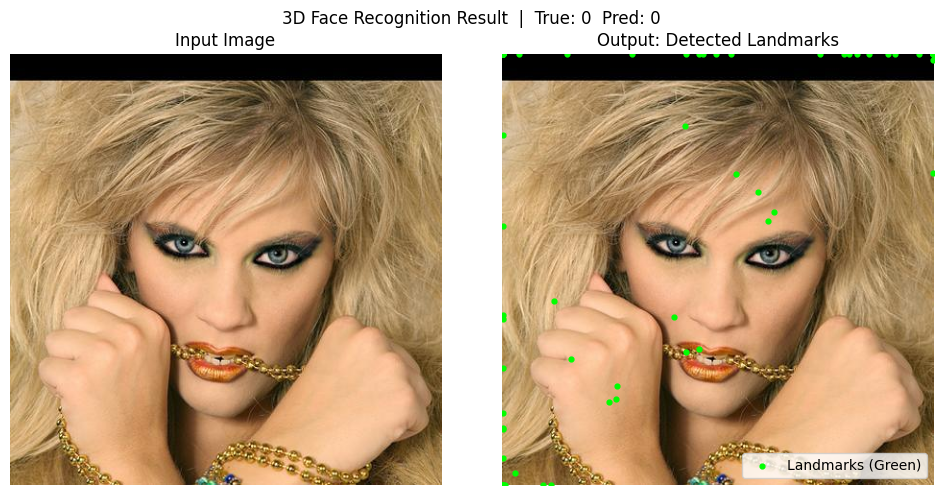

In [36]:
# ---------------------------
# Plot comparison: Input vs Output
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Input image
axes[0].imshow(img)
axes[0].set_title("Input Image")
axes[0].axis("off")
# Output: Image with green landmarks
axes[1].imshow(img)
axes[1].scatter(landmarks_2d[:, 0], landmarks_2d[:, 1], c='lime', s=12, label='Landmarks (Green)')
axes[1].set_title("Output: Detected Landmarks")
axes[1].axis("off")
axes[1].legend(loc="lower right")

plt.suptitle(f"3D Face Recognition Result  |  True: {y_true}  Pred: {y_pred_class}", fontsize=12)
plt.tight_layout()
plt.show()

13/13 [==============================] - 0s 25ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.8537    1.0000    0.9211        35
           1     1.0000    0.8205    0.9014        39
           2     0.9677    0.9375    0.9524        64
           3     0.9587    0.9355    0.9469       124
           4     0.8947    0.9714    0.9315        70
           5     0.9706    0.9706    0.9706        68

    accuracy                         0.9425       400
   macro avg     0.9409    0.9393    0.9373       400
weighted avg     0.9458    0.9425    0.9424       400



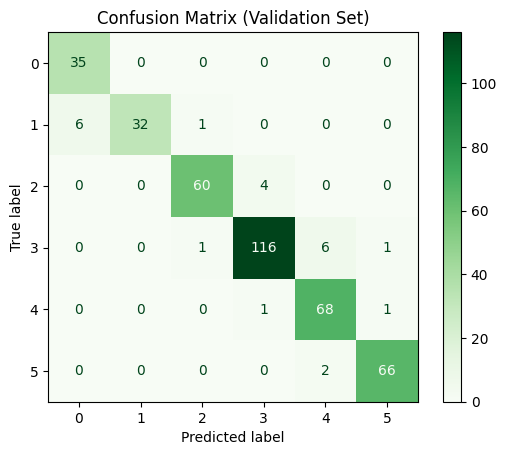

In [37]:
# ---------------------------
# Evaluate the model on test set (optional full metrics)
# ---------------------------
X_test, y_test = [], []
for f in test_files:
    d = np.load(f)
    X_test.append(d["X"])
    y_test.append(d["y"])

X_test = np.array(X_test)
y_test = np.array(y_test)
y_pred_all = np.argmax(model.predict(X_test), axis=1)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_all, digits=4))

cm = confusion_matrix(y_test, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix (Validation Set)")
plt.show()

In [ ]:

# ---------------------------
# t-SNE Visualization of ST-GCN Learned Embeddings
# ---------------------------

print("[INFO] Creating t-SNE visualization of ST-GCN learned embeddings...")

# Flatten input features for t-SNE
X_flattened = X_test.reshape(X_test.shape[0], -1)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(X_flattened)

# Plot with distinct clusters
plt.figure(figsize=(12, 10))
colors = ["red", "blue", "green", "orange", "purple", "brown"]
labels = [f"Identity {i}" for i in range(6)]

for i in range(6):
    mask = y_test == i
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                c=colors[i], label=labels[i], alpha=0.7, s=50)

plt.legend()
plt.title("t-SNE Visualization of ST-GCN Learned Embeddings\nShowing Distinct Clusters of Different Face Identities")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("tsne_stgcn_embeddings.png", dpi=300, bbox_inches="tight")
plt.show()

print("[INFO] t-SNE visualization saved as 'tsne_stgcn_embeddings.png'")
